In [20]:
import pandas as pd 

#read dataset
df = pd.read_csv("Spotify Youtube Dataset.csv")

#display first examples
df.head()

#Dropping features from the dataset that add no predictive value to the model
df = df.drop(columns=[
    'Track', 'Artist', 'Url_spotify', 'Uri', 'Url_youtube', 'Title', 'Channel', 'Description', 'Album', 'Album_type'])

#Sanity check and dropping duplicates
df = df.drop_duplicates()

#Check for missing data
print("NULL data: ",df.isnull().sum())

# Drop rows with missing target features
df = df.dropna(subset=['Views'])

# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_wo_views = [c for c in numeric_cols if c != 'Views']
df[numeric_cols_wo_views] = df[numeric_cols_wo_views].fillna(df[numeric_cols_wo_views].median())

# Fill categorical/boolean columns with mode
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Create popularity classes based on quantiles
df['popularity_class'] = pd.qcut(df['Views'], q=3, labels=['Low', 'Medium', 'High'])

# Drop the original 'views' column (to avoid leakage of target)
df = df.drop(columns=['Views'])

NULL data:  Unnamed: 0            0
Danceability          2
Energy                2
Key                   2
Loudness              2
Speechiness           2
Acousticness          2
Instrumentalness      2
Liveness              2
Valence               2
Tempo                 2
Duration_ms           2
Views               470
Likes               541
Comments            569
Licensed            470
official_video      470
Stream              576
dtype: int64


C:\Users\lesha\AppData\Local\Temp\ipykernel_15640\4110758838.py:30: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


0.8307818930041152


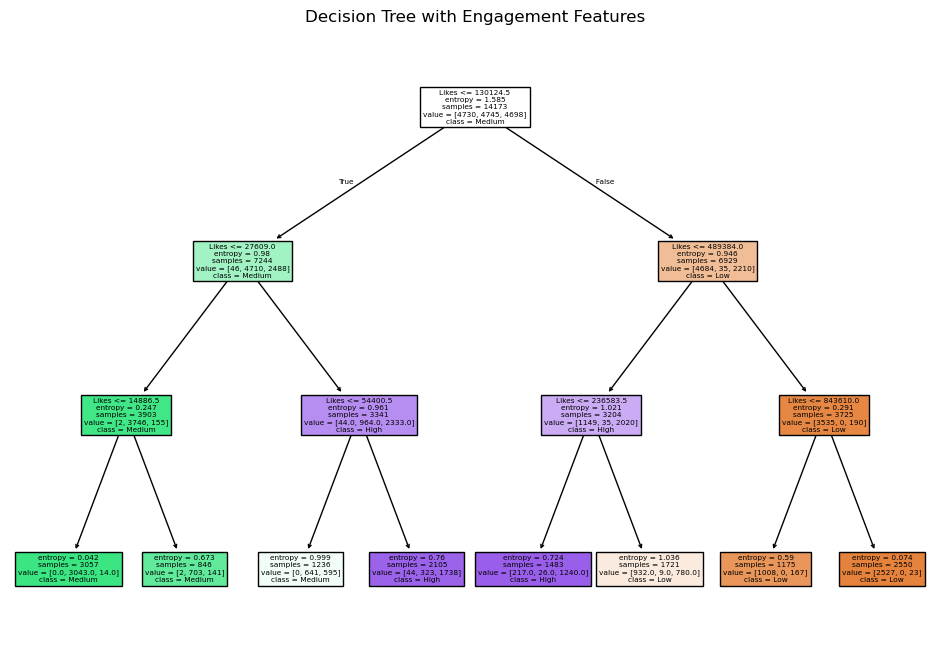

Classification Report:
               precision    recall  f1-score   support

        High       0.81      0.94      0.87      2020
         Low       0.85      0.92      0.88      2004
      Medium       0.83      0.64      0.72      2051

    accuracy                           0.83      6075
   macro avg       0.83      0.83      0.83      6075
weighted avg       0.83      0.83      0.82      6075

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.8585337779221571
0.8618930041152263


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import category_encoders as ce
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV


# Spliting the data with engagement features 
target = 'popularity_class'
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Categorial encoder for the popularity class 
encoder = ce.OrdinalEncoder(['popularity_class'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# Decision Tree Classifier 
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

# Display the decision tree
plt.figure(figsize= (12,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=y.cat.categories.astype(str), filled=True)
plt.title("Decision Tree with Engagement Features")
plt.show()

#Classification
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

#Finding best parameters and score
param_grid = {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid = param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

best = grid_search.best_estimator_
best_accuracy = best.score(X_test, y_test)
print(best_accuracy)

0.49234567901234566


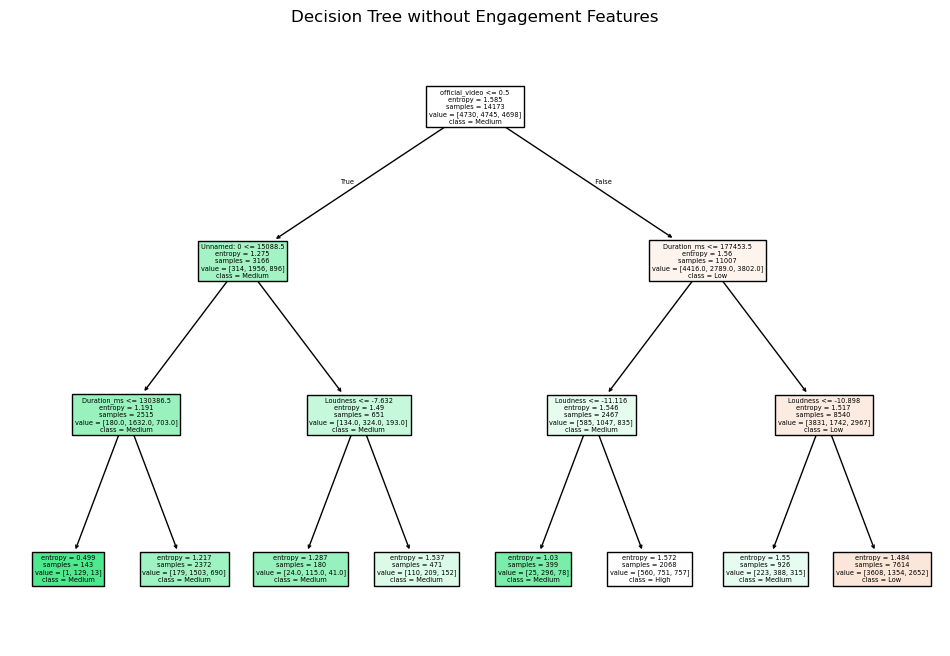

Classification Report:
               precision    recall  f1-score   support

        High       0.47      0.77      0.58      2020
         Low       0.58      0.54      0.56      2004
      Medium       0.39      0.17      0.24      2051

    accuracy                           0.49      6075
   macro avg       0.48      0.49      0.46      6075
weighted avg       0.48      0.49      0.46      6075

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.5224732929320085
0.5176954732510288


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import category_encoders as ce
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.metrics import classification_report

# Spliting the data with no engagement features
df = df.drop(columns=['Likes', 'Comments', 'Stream'])
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Categorial encoder for the popularity class 
encoder = ce.OrdinalEncoder(['popularity_class'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# Decision Tree Classifier 
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

# Display the decision tree
plt.figure(figsize= (12,8))
tree.plot_tree(clf, feature_names=X.columns, class_names=y.cat.categories.astype(str), filled=True)
plt.title("Decision Tree without Engagement Features")
plt.show()

#Classification
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

#Finding best parameters and score
param_grid = {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1,2,4],
        'criterion': ['gini', 'entropy']
    }

clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid = param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

best = grid_search.best_estimator_
best_accuracy = best.score(X_test, y_test)
print(best_accuracy)